In [6]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from datetime import datetime

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy

In [7]:
'''
MovieLens 20M Dataset
20,000,263 ratings
27,278 movies
138,493 users
'''

'\nMovieLens 20M Dataset\n20,000,263 ratings\n27,278 movies\n138,493 users\n'

In [10]:
# Load the data
current_path = os.getcwd()
file = '\\datasets\\movielens_data\\ratings.csv'
ratingDF = pd.read_csv(current_path + file)

In [11]:
# Convert fields into appropriate data types
ratingDF.userId = ratingDF.userId.astype(str).astype(int)
ratingDF.movieId = ratingDF.movieId.astype(str).astype(int)
ratingDF.rating = ratingDF.rating.astype(str).astype(float)
ratingDF.timestamp = ratingDF.timestamp.apply(lambda x: \
                    datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

In [ ]:
# Store DataFrame as pickle for faster loading in the future
pickle_file = '\\datasets\\movielens_data\\ratingPickle'
ratingDF.to_pickle(current_path + pickle_file)
ratingDF = pd.read_pickle(current_path + pickle_file)

In [ ]:
# Preview data
ratingDF.head()

In [ ]:
# Calculate summary statistics on full dataset

# 20,000,263 ratings
# 26,744 unique movies
# 138,493 unique users
# 144 ratings on average per user

n_users = ratingDF.userId.unique().shape[0]
n_movies = ratingDF.movieId.unique().shape[0]
n_ratings = len(ratingDF)
avg_ratings_per_user = n_ratings/n_users

print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

In [ ]:
# Reduce size of dataset by taking top 1000 movies
movieIndex = ratingDF.groupby("movieId").count().sort_values(by= \
                "rating",ascending=False)[0:1000].index
ratingDFX2 = ratingDF[ratingDF.movieId.isin(movieIndex)]
ratingDFX2.count()

In [ ]:
# Reduce size of dataset by sampling 1000 users
userIndex = ratingDFX2.groupby("userId").count().sort_values(by= \
    "rating",ascending=False).sample(n=1000, random_state=2018).index
ratingDFX3 = ratingDFX2[ratingDFX2.userId.isin(userIndex)]
ratingDFX3.count()

In [ ]:
# Reindex movie ID
movies = ratingDFX3.movieId.unique()
moviesDF = pd.DataFrame(data=movies,columns=['originalMovieId'])
moviesDF['newMovieId'] = moviesDF.index+1
moviesDF.head()

In [ ]:
# Reindex user ID
users = ratingDFX3.userId.unique()
usersDF = pd.DataFrame(data=users,columns=['originalUserId'])
usersDF['newUserId'] = usersDF.index+1
usersDF.head()

In [ ]:
# Generate newly merged DataFrame
ratingDFX3 = ratingDFX3.merge(moviesDF,left_on='movieId', \
                              right_on='originalMovieId')
ratingDFX3.drop(labels='originalMovieId', axis=1, inplace=True)

ratingDFX3 = ratingDFX3.merge(usersDF,left_on='userId', \
                              right_on='originalUserId')
ratingDFX3.drop(labels='originalUserId', axis=1, inplace=True)
ratingDFX3.head()

In [ ]:
# Save as pickle
pickle_file = '\\datasets\\movielens_data\\ratingReducedPickle'
ratingDFX3.to_pickle(current_path + pickle_file)
ratingDFX3 = pd.read_pickle(current_path + pickle_file)

In [ ]:
# Calculate summary statistics on reduced dataset
n_users = ratingDFX3.userId.unique().shape[0]
n_movies = ratingDFX3.movieId.unique().shape[0]
n_ratings = len(ratingDFX3)
avg_ratings_per_user = n_ratings/n_users

print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

In [ ]:
# Split into validation and test, such that each is 5% of the dataset
X_train, X_test = train_test_split(ratingDFX3, test_size=0.10, \
                                   shuffle=True, random_state=2018)

X_validation, X_test = train_test_split(X_test, test_size=0.50, \
                                        shuffle=True, random_state=2018)

In [ ]:
# Confirm size of train, validation, and test datasets
print('Size of train set: ', len(X_train))
print('Size of validation set: ', len(X_validation))
print('Size of test set: ', len(X_test))

In [ ]:
# Generate ratings matrix for train
ratings_train = np.zeros((n_users, n_movies))
for row in X_train.itertuples():
    ratings_train[row[6]-1, row[5]-1] = row[3]

In [ ]:
ratings_train.shape

In [ ]:
# Calculate sparsity of the train ratings matrix
sparsity = float(len(ratings_train.nonzero()[0]))
sparsity /= (ratings_train.shape[0] * ratings_train.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

In [ ]:
# Generate ratings matrix for validation
ratings_validation = np.zeros((n_users, n_movies))
for row in X_validation.itertuples():
    ratings_validation[row[6]-1, row[5]-1] = row[3]

In [ ]:
# Generate ratings matrix for test
ratings_test = np.zeros((n_users, n_movies))
for row in X_test.itertuples():
    ratings_test[row[6]-1, row[5]-1] = row[3]

In [ ]:
# Calculate sparsity of the validation ratings matrix
sparsity = float(len(ratings_validation.nonzero()[0]))
sparsity /= (ratings_validation.shape[0] * ratings_validation.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

In [ ]:
# Experiment one - Assign naive 3.5 rating and calculate baseline MSE

In [ ]:
actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()

In [ ]:
pred_validation = np.zeros((len(X_validation),1))
pred_validation[pred_validation==0] = 3.5

In [ ]:
naive_prediction = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using naive prediction:', naive_prediction)

In [ ]:
# Experiment two - Predict a user's rating based on user's average rating 
# for all other movies

In [ ]:
ratings_validation_prediction = np.zeros((n_users, n_movies))
i = 0
for row in ratings_train:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] \
        = np.mean(row[row>0])
    i += 1

pred_validation = ratings_validation_prediction \
    [ratings_validation.nonzero()].flatten()
user_average = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using user average:', user_average)

In [ ]:
# Experiment three - Predict a user's rating for a movie based on the
# average rating other users have given that movie

In [ ]:
ratings_validation_prediction = np.zeros((n_users, n_movies)).T
i = 0
for row in ratings_train.T:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] \
        = np.mean(row[row>0])
    i += 1

ratings_validation_prediction = ratings_validation_prediction.T
pred_validation = ratings_validation_prediction \
    [ratings_validation.nonzero()].flatten()
movie_average = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using movie average:', movie_average)

In [ ]:
# Experiment four - Recommender System using Matrix Factorization
# 1 Latent Factor

In [40]:
n_latent_factors = 1

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, \
                           output_dim=n_latent_factors, \
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, \
                            output_dim=n_latent_factors,
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [41]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], \
                    y=X_train.rating, epochs=100, \
                    validation_data=([X_validation.newUserId, \
                    X_validation.newMovieId], X_validation.rating), \
                    verbose=1)

Train on 81191 samples, validate on 4511 samples
Epoch 1/100
81191/81191 [==============================] - 2s 24us/step - loss: 13.6738 - val_loss: 11.9761
Epoch 2/100
81191/81191 [==============================] - 1s 18us/step - loss: 9.2477 - val_loss: 6.6411
Epoch 3/100
81191/81191 [==============================] - 1s 18us/step - loss: 4.7246 - val_loss: 3.3975
Epoch 4/100
81191/81191 [==============================] - 1s 18us/step - loss: 2.5899 - val_loss: 2.0820
Epoch 5/100
81191/81191 [==============================] - 1s 18us/step - loss: 1.6664 - val_loss: 1.4599
Epoch 6/100
81191/81191 [==============================] - 2s 21us/step - loss: 1.2105 - val_loss: 1.1479
Epoch 7/100
81191/81191 [==============================] - 2s 25us/step - loss: 0.9796 - val_loss: 0.9851
Epoch 8/100
81191/81191 [==============================] - 2s 24us/step - loss: 0.8611 - val_loss: 0.8981
Epoch 9/100
81191/81191 [==============================] - 2s 24us/step - loss: 0.7996 - val_loss: 0.

Epoch 77/100
81191/81191 [==============================] - 2s 19us/step - loss: 0.7277 - val_loss: 0.7980
Epoch 78/100
81191/81191 [==============================] - 1s 18us/step - loss: 0.7277 - val_loss: 0.7967
Epoch 79/100
81191/81191 [==============================] - 1s 18us/step - loss: 0.7277 - val_loss: 0.7957
Epoch 80/100
81191/81191 [==============================] - 1s 18us/step - loss: 0.7279 - val_loss: 0.7972
Epoch 81/100
81191/81191 [==============================] - 1s 18us/step - loss: 0.7276 - val_loss: 0.7972
Epoch 82/100
81191/81191 [==============================] - 1s 18us/step - loss: 0.7277 - val_loss: 0.7975
Epoch 83/100
81191/81191 [==============================] - 1s 18us/step - loss: 0.7278 - val_loss: 0.7980
Epoch 84/100
81191/81191 [==============================] - 1s 18us/step - loss: 0.7278 - val_loss: 0.7977
Epoch 85/100
81191/81191 [==============================] - 1s 18us/step - loss: 0.7277 - val_loss: 0.7972
Epoch 86/100
81191/81191 [===========

Minimum MSE:  0.7960410582149829


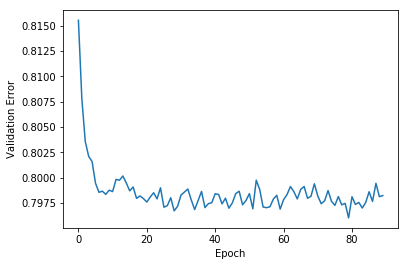

In [54]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

In [ ]:
# Experiment five - Recommender System using Matrix Factorization
# 3 Latent Factors

In [55]:
n_latent_factors = 3

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, \
                           output_dim=n_latent_factors, \
                           embeddings_regularizer=regularizers.l1(10e-7), \
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, \
                            output_dim=n_latent_factors, \
                            embeddings_regularizer=regularizers.l1(10e-7), \
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [56]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], \
                    y=X_train.rating, epochs=100, \
                    validation_data=([X_validation.newUserId, \
                    X_validation.newMovieId], X_validation.rating), \
                    verbose=1)

Train on 81191 samples, validate on 4511 samples
Epoch 1/100
81191/81191 [==============================] - 7s 88us/step - loss: 12.3087 - val_loss: 8.0564
Epoch 2/100
81191/81191 [==============================] - 7s 81us/step - loss: 4.5733 - val_loss: 2.5908
Epoch 3/100
81191/81191 [==============================] - 7s 83us/step - loss: 1.8096 - val_loss: 1.3787
Epoch 4/100
81191/81191 [==============================] - 8s 94us/step - loss: 1.0896 - val_loss: 1.0038
Epoch 5/100
81191/81191 [==============================] - 7s 92us/step - loss: 0.8605 - val_loss: 0.8752
Epoch 6/100
81191/81191 [==============================] - 8s 93us/step - loss: 0.7839 - val_loss: 0.8311
Epoch 7/100
81191/81191 [==============================] - 7s 91us/step - loss: 0.7578 - val_loss: 0.8124
Epoch 8/100
81191/81191 [==============================] - 8s 92us/step - loss: 0.7481 - val_loss: 0.8100
Epoch 9/100
81191/81191 [==============================] - 7s 91us/step - loss: 0.7442 - val_loss: 0.8

Minimum MSE:  0.764993456984486


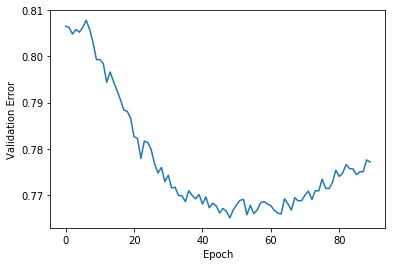

In [57]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

In [58]:
# Experiment six - Recommender System using Matrix Factorization
# 5 Latent Factors

In [59]:
n_latent_factors = 5

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, \
                           output_dim=n_latent_factors, \
                           embeddings_regularizer=regularizers.l1(10e-7), \
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, \
                            output_dim=n_latent_factors, \
                            embeddings_regularizer=regularizers.l1(10e-7), \
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [60]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], \
                    y=X_train.rating, epochs=100, \
                    validation_data=([X_validation.newUserId, \
                    X_validation.newMovieId], X_validation.rating), \
                    verbose=1)

Train on 81191 samples, validate on 4511 samples
Epoch 1/100
81191/81191 [==============================] - 8s 99us/step - loss: 11.0785 - val_loss: 5.3587
Epoch 2/100
81191/81191 [==============================] - 8s 92us/step - loss: 2.8833 - val_loss: 1.6881
Epoch 3/100
81191/81191 [==============================] - 7s 91us/step - loss: 1.2260 - val_loss: 1.0363
Epoch 4/100
81191/81191 [==============================] - 7s 92us/step - loss: 0.8703 - val_loss: 0.8705
Epoch 5/100
81191/81191 [==============================] - 8s 92us/step - loss: 0.7815 - val_loss: 0.8277
Epoch 6/100
81191/81191 [==============================] - 7s 91us/step - loss: 0.7585 - val_loss: 0.8170
Epoch 7/100
81191/81191 [==============================] - 7s 92us/step - loss: 0.7527 - val_loss: 0.8124
Epoch 8/100
81191/81191 [==============================] - 8s 94us/step - loss: 0.7506 - val_loss: 0.8114
Epoch 9/100
81191/81191 [==============================] - 8s 97us/step - loss: 0.7494 - val_loss: 0.8

Minimum MSE:  0.772592930750423


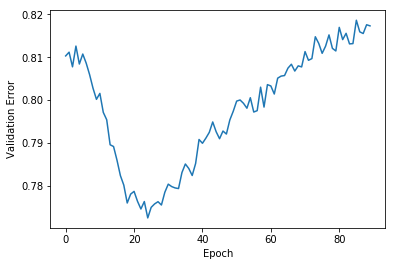

In [61]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

In [ ]:
# Experiment seven - Recommender System using RBMs

In [42]:
# Define RBM class
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # Define hyperparameters
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        # Initialize weights and biases using zero matrices
        self.w = np.zeros([input_size, output_size], dtype=np.float32)
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)

    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.placeholder(tf.float32, [self._input_size, self._output_size])
        _hb = tf.placeholder(tf.float32, [self._output_size])
        _vb = tf.placeholder(tf.float32, [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)
        
        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)
        
        v0 = tf.placeholder(tf.float32, [None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * \
            (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        error_list = []
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), \
                        self.batchsize),range(self.batchsize,len(X), \
                                              self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, \
                                _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list

    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)

In [50]:
# Begin the training cycle

# Convert inputX into float32
inputX = ratings_train
inputX = inputX.astype(np.float32)

# Define the parameters of the RBMs we will train
rbm=RBM(1000,1000,1,1000,200)

In [51]:
# Train RBM model
err = rbm.train(inputX)
outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)

Epoch: 0 reconstruction error: 1.103580
Epoch: 1 reconstruction error: 1.067670
Epoch: 2 reconstruction error: 1.084486
Epoch: 3 reconstruction error: 1.089314
Epoch: 4 reconstruction error: 1.096305
Epoch: 5 reconstruction error: 1.089308
Epoch: 6 reconstruction error: 1.092914
Epoch: 7 reconstruction error: 1.091459
Epoch: 8 reconstruction error: 1.090788
Epoch: 9 reconstruction error: 1.086923
Epoch: 10 reconstruction error: 1.093178
Epoch: 11 reconstruction error: 1.091110
Epoch: 12 reconstruction error: 1.089425
Epoch: 13 reconstruction error: 1.092257
Epoch: 14 reconstruction error: 1.090363
Epoch: 15 reconstruction error: 1.099082
Epoch: 16 reconstruction error: 1.088691
Epoch: 17 reconstruction error: 1.093853
Epoch: 18 reconstruction error: 1.091068
Epoch: 19 reconstruction error: 1.095680
Epoch: 20 reconstruction error: 1.093904
Epoch: 21 reconstruction error: 1.095088
Epoch: 22 reconstruction error: 1.095520
Epoch: 23 reconstruction error: 1.097222
Epoch: 24 reconstruction e

Epoch: 198 reconstruction error: 1.082872
Epoch: 199 reconstruction error: 1.083424
Epoch: 200 reconstruction error: 1.082541
Epoch: 201 reconstruction error: 1.083001
Epoch: 202 reconstruction error: 1.083094
Epoch: 203 reconstruction error: 1.082729
Epoch: 204 reconstruction error: 1.082118
Epoch: 205 reconstruction error: 1.082765
Epoch: 206 reconstruction error: 1.082713
Epoch: 207 reconstruction error: 1.082715
Epoch: 208 reconstruction error: 1.082296
Epoch: 209 reconstruction error: 1.083189
Epoch: 210 reconstruction error: 1.082114
Epoch: 211 reconstruction error: 1.082651
Epoch: 212 reconstruction error: 1.081797
Epoch: 213 reconstruction error: 1.082083
Epoch: 214 reconstruction error: 1.082487
Epoch: 215 reconstruction error: 1.082080
Epoch: 216 reconstruction error: 1.081507
Epoch: 217 reconstruction error: 1.082562
Epoch: 218 reconstruction error: 1.081161
Epoch: 219 reconstruction error: 1.082610
Epoch: 220 reconstruction error: 1.081349
Epoch: 221 reconstruction error: 1

Epoch: 394 reconstruction error: 1.075825
Epoch: 395 reconstruction error: 1.076350
Epoch: 396 reconstruction error: 1.076483
Epoch: 397 reconstruction error: 1.075997
Epoch: 398 reconstruction error: 1.076452
Epoch: 399 reconstruction error: 1.076581
Epoch: 400 reconstruction error: 1.076581
Epoch: 401 reconstruction error: 1.076615
Epoch: 402 reconstruction error: 1.076877
Epoch: 403 reconstruction error: 1.075861
Epoch: 404 reconstruction error: 1.076625
Epoch: 405 reconstruction error: 1.076108
Epoch: 406 reconstruction error: 1.076156
Epoch: 407 reconstruction error: 1.076077
Epoch: 408 reconstruction error: 1.076141
Epoch: 409 reconstruction error: 1.075735
Epoch: 410 reconstruction error: 1.075858
Epoch: 411 reconstruction error: 1.076386
Epoch: 412 reconstruction error: 1.076174
Epoch: 413 reconstruction error: 1.075555
Epoch: 414 reconstruction error: 1.075922
Epoch: 415 reconstruction error: 1.075698
Epoch: 416 reconstruction error: 1.076264
Epoch: 417 reconstruction error: 1

Epoch: 590 reconstruction error: 1.073828
Epoch: 591 reconstruction error: 1.073675
Epoch: 592 reconstruction error: 1.073591
Epoch: 593 reconstruction error: 1.073920
Epoch: 594 reconstruction error: 1.073390
Epoch: 595 reconstruction error: 1.073751
Epoch: 596 reconstruction error: 1.073678
Epoch: 597 reconstruction error: 1.073542
Epoch: 598 reconstruction error: 1.073671
Epoch: 599 reconstruction error: 1.073830
Epoch: 600 reconstruction error: 1.073617
Epoch: 601 reconstruction error: 1.073681
Epoch: 602 reconstruction error: 1.073472
Epoch: 603 reconstruction error: 1.073838
Epoch: 604 reconstruction error: 1.073414
Epoch: 605 reconstruction error: 1.073514
Epoch: 606 reconstruction error: 1.073078
Epoch: 607 reconstruction error: 1.073923
Epoch: 608 reconstruction error: 1.073853
Epoch: 609 reconstruction error: 1.073552
Epoch: 610 reconstruction error: 1.073356
Epoch: 611 reconstruction error: 1.073879
Epoch: 612 reconstruction error: 1.073311
Epoch: 613 reconstruction error: 1

Epoch: 786 reconstruction error: 1.073007
Epoch: 787 reconstruction error: 1.072942
Epoch: 788 reconstruction error: 1.072551
Epoch: 789 reconstruction error: 1.073091
Epoch: 790 reconstruction error: 1.072731
Epoch: 791 reconstruction error: 1.073544
Epoch: 792 reconstruction error: 1.072592
Epoch: 793 reconstruction error: 1.073082
Epoch: 794 reconstruction error: 1.072965
Epoch: 795 reconstruction error: 1.073195
Epoch: 796 reconstruction error: 1.072582
Epoch: 797 reconstruction error: 1.073105
Epoch: 798 reconstruction error: 1.072837
Epoch: 799 reconstruction error: 1.072971
Epoch: 800 reconstruction error: 1.072974
Epoch: 801 reconstruction error: 1.072979
Epoch: 802 reconstruction error: 1.072620
Epoch: 803 reconstruction error: 1.073233
Epoch: 804 reconstruction error: 1.072994
Epoch: 805 reconstruction error: 1.072956
Epoch: 806 reconstruction error: 1.073120
Epoch: 807 reconstruction error: 1.072904
Epoch: 808 reconstruction error: 1.072446
Epoch: 809 reconstruction error: 1

Epoch: 982 reconstruction error: 1.072469
Epoch: 983 reconstruction error: 1.072577
Epoch: 984 reconstruction error: 1.072410
Epoch: 985 reconstruction error: 1.072569
Epoch: 986 reconstruction error: 1.072608
Epoch: 987 reconstruction error: 1.072559
Epoch: 988 reconstruction error: 1.072405
Epoch: 989 reconstruction error: 1.072505
Epoch: 990 reconstruction error: 1.072479
Epoch: 991 reconstruction error: 1.072482
Epoch: 992 reconstruction error: 1.072531
Epoch: 993 reconstruction error: 1.072299
Epoch: 994 reconstruction error: 1.072525
Epoch: 995 reconstruction error: 1.072495
Epoch: 996 reconstruction error: 1.072340
Epoch: 997 reconstruction error: 1.072526
Epoch: 998 reconstruction error: 1.072466
Epoch: 999 reconstruction error: 1.072557


Text(0,0.5,'Reconstruction Error')

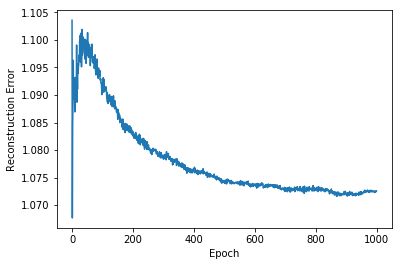

In [52]:
# Plot reconstruction errors
pd.Series(err).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")

In [53]:
# Predict ratings for validation set
inputValidation = ratings_validation
inputValidation = inputValidation.astype(np.float32)

finalOutput_validation, reconstructedOutput_validation, _ = \
    rbm.rbm_output(inputValidation)

In [63]:
# Calculate MSE on validation set
predictionsArray = reconstructedOutput_validation
pred_validation = \
    predictionsArray[ratings_validation.nonzero()].flatten()
actual_validation = \
    ratings_validation[ratings_validation.nonzero()].flatten()

rbm_prediction = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using RBM prediction:', rbm_prediction)

Mean squared error using RBM prediction: 9.331135003325205
